# Brain Tumor Segmentation Using U-Net

## Introduction

Brain tumors are among the most dangerous and life-threatening forms of cancer. Accurate detection and segmentation of brain tumors from MRI scans is critical for diagnosis, treatment planning, and monitoring of disease progression. Manual segmentation by radiologists is time-consuming and subject to variability, which motivates the need for automated and reliable segmentation systems.

In this notebook, A **U-Net based deep learning model** is developed to automatically segment brain tumors from MRI images using the **[Brain Tumor Segmentation dataset](https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation)** on Kaggle.

## Objectives

- Preprocess MRI images and corresponding segmentation masks.
- Implement a U-Net architecture tailored for binary segmentation of brain tumors.
- Train the U-Net model and evaluate its performance using metrics such as Dice coefficient and IoU.
- Visualize the predicted tumor masks to assess segmentation quality.

## Dataset Overview

- **Total Images**: 3,264 MRI scans with corresponding masks.
- **Image Format**: PNG

## Why U-Net?

U-Net is a popular convolutional neural network architecture designed specifically for biomedical image segmentation. Its encoder-decoder structure with skip connections allows it to capture both high-level context and fine-grained details, making it particularly well-suited for tasks like tumor segmentation.

This notebook walks through the full segmentation pipeline, from data loading and preprocessing to model training, evaluation, and visualization of the segmentation results.


## Importing necessary libraries

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from tqdm import tqdm
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## Data Loading and Preprocessing

In [3]:
IMAGE_SIZE = (256,256)

In [4]:
root_path = '/kaggle/input/brain-tumor-segmentation'
os.listdir(root_path)

['images', 'masks']

In [6]:
images_path = os.path.join(root_path, 'images')
masks_path = os.path.join(root_path, 'masks')

print(f"Images path: {images_path}")
print(f"Masks path: {masks_path}")

Images path: /kaggle/input/brain-tumor-segmentation/images
Masks path: /kaggle/input/brain-tumor-segmentation/masks


In [7]:
image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

print(f"Image files:{image_files[:10]}")
print(f"Mask files:{mask_files[:10]}")

Image files:['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']
Mask files:['1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png', '1006.png']


In [8]:
print("Number of images:",len(image_files))
print("Number of masks:", len(mask_files))

Number of images: 3064
Number of masks: 3064


In [9]:
def load_and_preprocess_data(images_path, masks_path, img_size):
  '''
  Loads and preprocesses the images and masks from the given paths.
  '''
  images = []
  masks = []

  for img_file, mask_file in tqdm(zip(image_files, mask_files), desc = "Loading:..."):
    image_path = os.path.join(images_path, img_file)
    mask_path = os.path.join(masks_path, mask_file)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, img_size)
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = mask / 255.0

    images.append(image)
    masks.append(mask)

  images = np.expand_dims(np.array(images), axis = -1)
  masks = np.expand_dims(np.array(masks), axis = -1)

  return images, masks

In [10]:
x, y = load_and_preprocess_data(images_path, masks_path, IMAGE_SIZE)

Loading:...: 3064it [01:09, 44.37it/s]


In [11]:
print('x_shape is:', x.shape)
print('y_shape is:',y.shape)

x_shape is: (3064, 256, 256, 1)
y_shape is: (3064, 256, 256, 1)


In [12]:
# Data Splitting:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 42)

In [13]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"\nx_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (2451, 256, 256, 1)
y_train shape: (2451, 256, 256, 1)

x_test shape: (613, 256, 256, 1)
y_test shape: (613, 256, 256, 1)


In [14]:
# Deleting for memory management:

del x,y

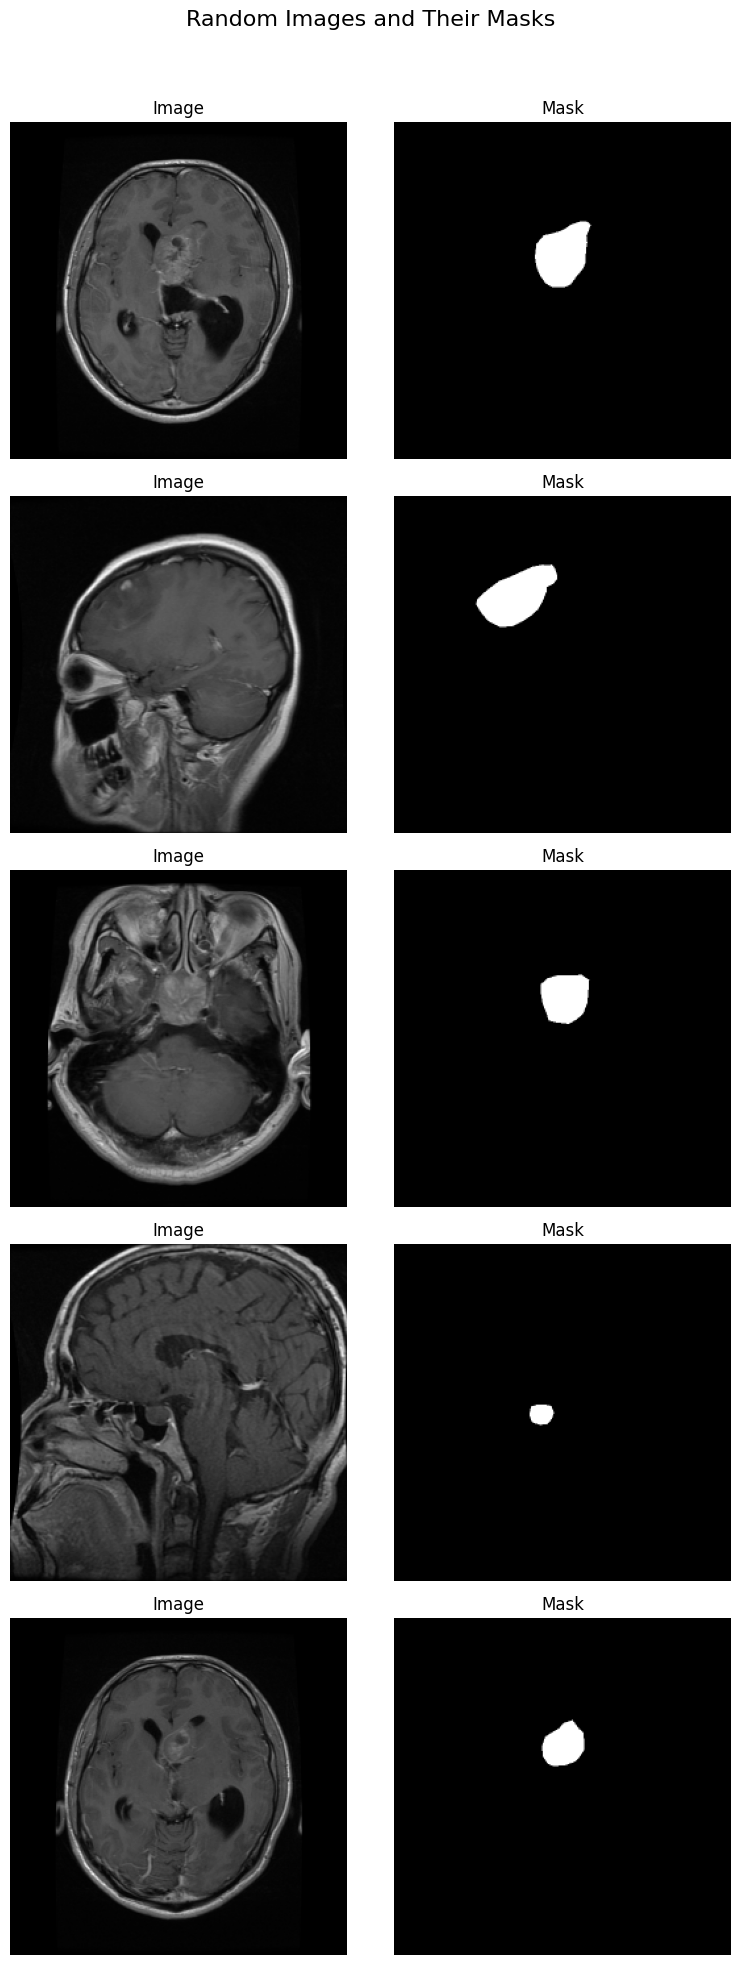

In [15]:
# Visualizing some images:

N_ROWS = 5

fig, axes = plt.subplots(N_ROWS, 2, figsize=(8, N_ROWS * 4))
fig.suptitle("Random Images and Their Masks", fontsize=16)

for i in range(N_ROWS):
    random_idx = np.random.randint(low=0, high=len(x_train))
    img_i = x_train[random_idx]
    mask_i = y_train[random_idx]

    axes[i, 0].imshow(img_i, cmap="gray")
    axes[i, 0].set_title("Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(mask_i, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## U-Net

### *Building*

In [28]:
def build_unet_model(input_size = (256, 256, 1), num_classes = 1):
  inputs = Input(input_size)

  # Encoder
  c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c2)
  p2 = MaxPooling2D((2, 2))(c2)

  c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c3)
  p3 = MaxPooling2D((2, 2))(c3)

  c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(c4)
  p4 = MaxPooling2D((2, 2))(c4)

  # Bottleneck
  b1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p4)
  b1 = Dropout(0.3)(b1)
  b1 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(b1)

  # Decoder
  u1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding = 'same', kernel_initializer = 'he_normal')(b1)
  u1 = Concatenate()([u1, c4])
  u1 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u1)
  u1 = Dropout(0.2)(u1)
  u1 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u1)

  u2 = Conv2DTranspose(256, (2, 2), strides=(2, 2),padding = 'same', kernel_initializer = 'he_normal')(u1)
  u2 = Concatenate()([u2, c3])
  u2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u2)
  u2 = Dropout(0.2)(u2)
  u2 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u2)

  u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2),padding = 'same', kernel_initializer = 'he_normal')(u2)
  u3 = Concatenate()([u3, c2])
  u3 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u3)
  u3 = Dropout(0.1)(u3)
  u3 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u3)
  
  u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding = 'same', kernel_initializer = 'he_normal')(u3)
  u4 = Concatenate()([u4, c1])
  u4 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u4)
  u4 = Dropout(0.1)(u4)
  u4 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u4)

  outputs = Conv2D(num_classes, (1, 1), activation = 'sigmoid')(u4)

  model = Model(inputs, outputs)

  return model

In [29]:
model = build_unet_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d_38[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 128, 128,  │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_40[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 64,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_42[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 32,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 16, 16,    │          0 │ conv2d_45[0][0] 

 Total params: 8,934,417 (34.08 MB)

 Trainable params: 8,934,417 (34.08 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Defining some metrics:

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)
    

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

In [34]:
opt = Adam(learning_rate = 1e-4)

model.compile(optimizer = opt, 
              loss = dice_loss, 
              metrics = [dice_coefficient, iou_metric])

In [35]:
# CALLBACK 1:

checkpoint_dir = 'model_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath = os.path.join(checkpoint_dir, 'best_segmentation_model.h5'),
    monitor = 'val_loss',
    save_best_only = True,
    save_weights_only = False,
    mode = 'min',
    verbose = 1)

# CALLBACK 2:

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.0001,
    patience = 10,
    verbose = 1,
    mode = 'min',
    restore_best_weights = True)

# CALLBACK 3:

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss',
                                            patience = 6,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-7,
                                            mode = 'min')

CALLBACKS = [checkpoint, early_stopping, learning_rate_reduction]

### *Training*

In [ ]:
history = model.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_data = (x_test, y_test),
                    verbose = 1, callbacks = CALLBACKS)

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - dice_coefficient: 0.7602 - iou_metric: 0.6151 - loss: 0.2398
Epoch 1: val_loss improved from inf to 0.33778, saving model to model_checkpoints/best_segmentation_model.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 77s 760ms/step - dice_coefficient: 0.7601 - iou_metric: 0.6151 - loss: 0.2399 - val_dice_coefficient: 0.6522 - val_iou_metric: 0.4881 - val_loss: 0.3378 - learning_rate: 1.0000e-04
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - dice_coefficient: 0.7748 - iou_metric: 0.6342 - loss: 0.2252
Epoch 2: val_loss improved from 0.33778 to 0.32896, saving model to model_checkpoints/best_segmentation_model.h5
77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 641ms/step - dice_coefficient: 0.7748 - iou_metric: 0.6341 - loss: 0.2252 - val_dice_coefficient: 0.6672 - val_iou_metric: 0.5027 - val_loss: 0.3290 - learning_rate: 1.0000e-04
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - dice_coefficient: 0.7702 - iou_metric: 0.6282 - loss: 0.2298
Epoch 3: val_l

***Comment:** Here the model stopped training due to an internet issue, i will reload the model again.*

In [41]:
model = load_model('/kaggle/working/model_checkpoints/best_segmentation_model.h5', compile = False)

In [42]:
opt = Adam(learning_rate = 1e-4)

model.compile(optimizer = opt, 
              loss = dice_loss, 
              metrics = [dice_coefficient, iou_metric])

In [43]:
history2 = model.fit(x_train, y_train, batch_size = 32, epochs = 44, validation_data = (x_test, y_test),
                     verbose = 1, callbacks = CALLBACKS)

Epoch 1/44
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - dice_coefficient: 0.9175 - iou_metric: 0.8480 - loss: 0.0825
Epoch 1: val_loss did not improve from 0.21407
77/77 ━━━━━━━━━━━━━━━━━━━━ 80s 801ms/step - dice_coefficient: 0.9175 - iou_metric: 0.8479 - loss: 0.0825 - val_dice_coefficient: 0.7682 - val_iou_metric: 0.6281 - val_loss: 0.2213 - learning_rate: 1.0000e-04
Epoch 2/44
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - dice_coefficient: 0.9067 - iou_metric: 0.8302 - loss: 0.0933
Epoch 2: val_loss did not improve from 0.21407
77/77 ━━━━━━━━━━━━━━━━━━━━ 50s 650ms/step - dice_coefficient: 0.9068 - iou_metric: 0.8303 - loss: 0.0932 - val_dice_coefficient: 0.7683 - val_iou_metric: 0.6290 - val_loss: 0.2194 - learning_rate: 1.0000e-04
Epoch 3/44
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - dice_coefficient: 0.9067 - iou_metric: 0.8298 - loss: 0.0933
Epoch 3: val_loss did not improve from 0.21407
77/77 ━━━━━━━━━━━━━━━━━━━━ 49s 631ms/step - dice_coefficient: 0.9068 - iou_metric: 0.8298 - loss: 

In [44]:
model.evaluate(x_test,y_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - dice_coefficient: 0.7900 - iou_metric: 0.6549 - loss: 0.2086


[0.20367291569709778, 0.7822339534759521, 0.6487836241722107]

In [45]:
# Combining histories together for visualization:

combined_history = {}

for key in history.history:
    combined_history[key] = history.history[key] + history2.history[key]

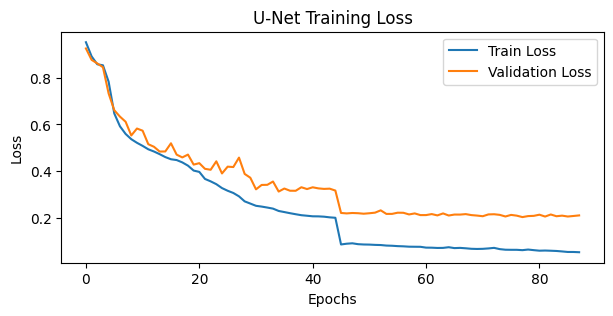

In [47]:
plt.figure(figsize=(7, 3))
plt.title("U-Net Training Loss")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

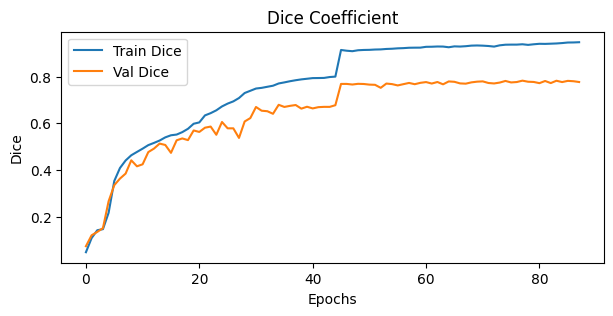

In [48]:
plt.figure(figsize=(7, 3))
plt.title("Dice Coefficient")
plt.ylabel('Dice')
plt.xlabel('Epochs')
plt.plot(combined_history['dice_coefficient'], label='Train Dice')
plt.plot(combined_history['val_dice_coefficient'], label='Val Dice')
plt.legend()
plt.show()

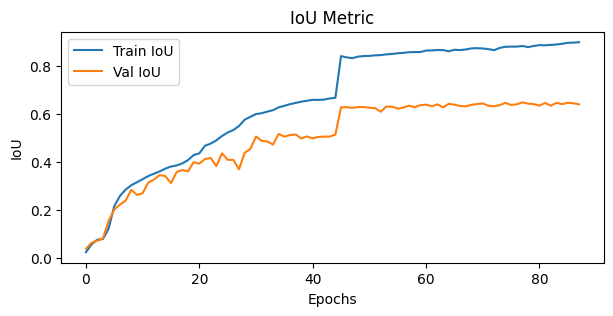

In [49]:
plt.figure(figsize=(7, 3))
plt.title("IoU Metric")
plt.ylabel('IoU')
plt.xlabel('Epochs')
plt.plot(combined_history['iou_metric'], label='Train IoU')
plt.plot(combined_history['val_iou_metric'], label='Val IoU')
plt.legend()
plt.show()

### *Evaluation*

In [50]:
y_pred = model.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 245ms/step


In [51]:
y_pred = (y_pred > 0.5).astype(np.uint8)

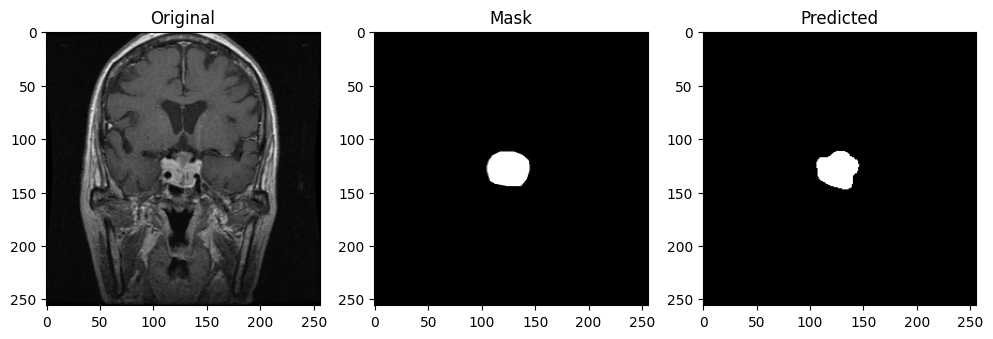

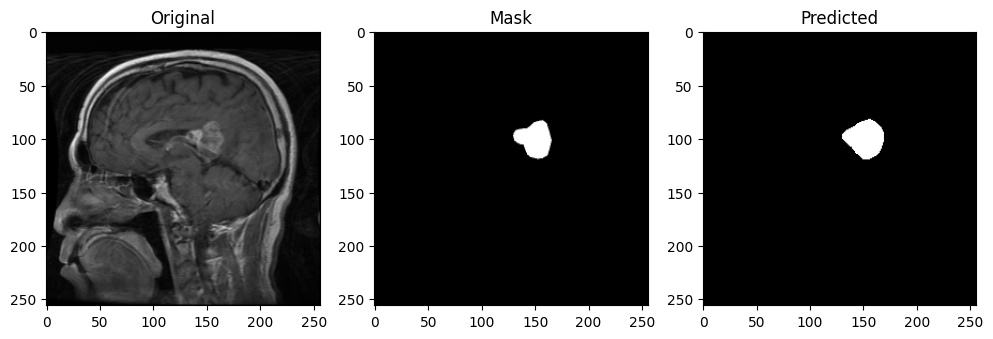

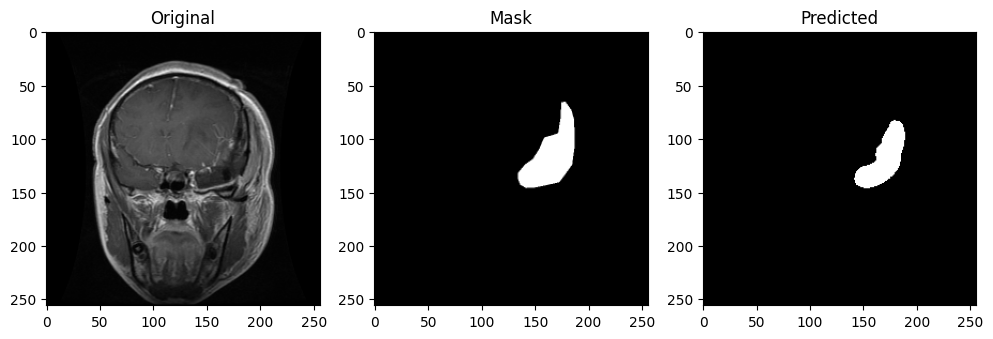

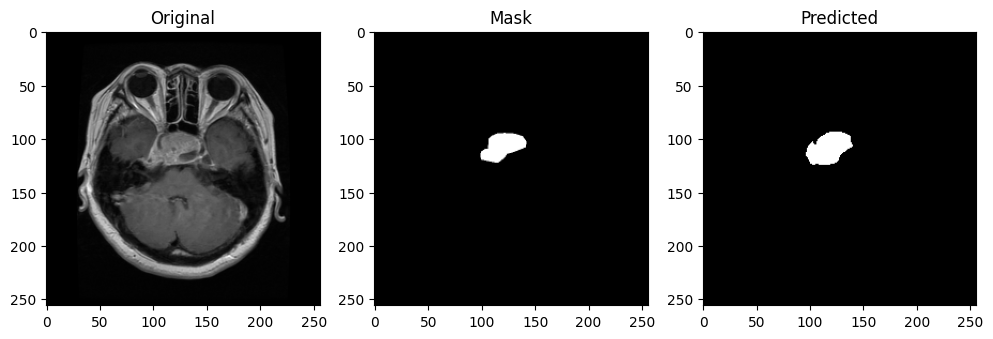

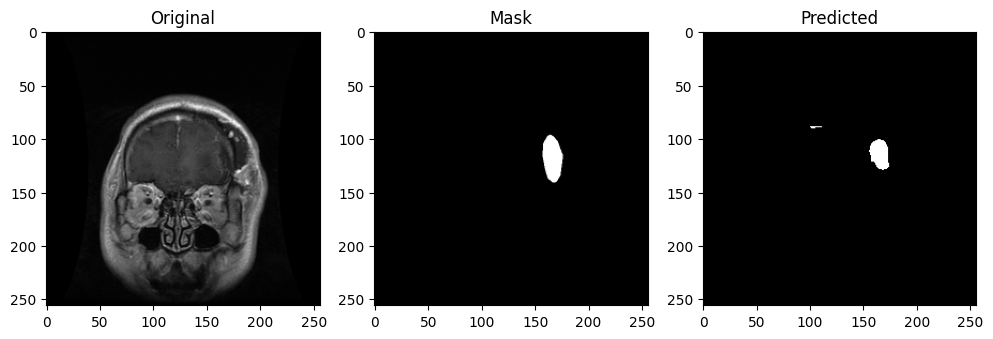

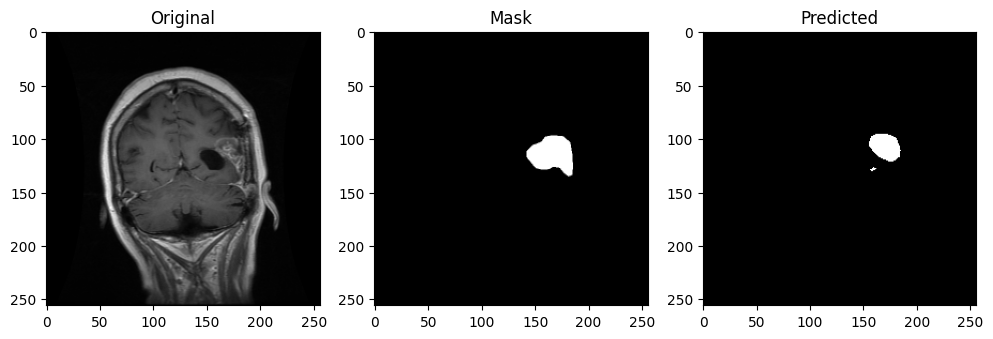

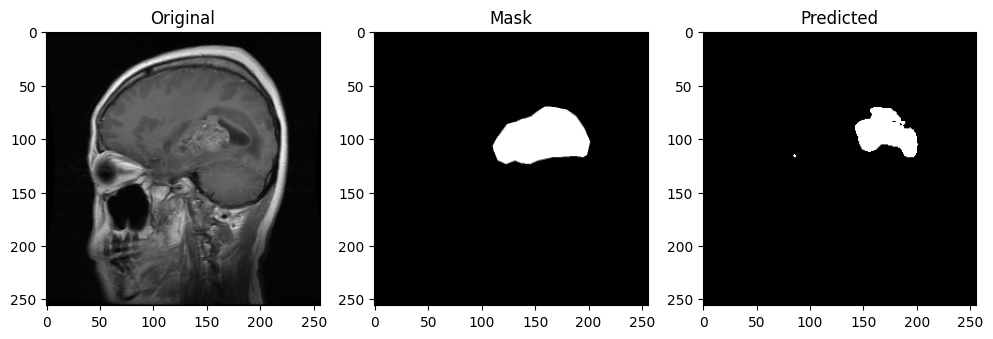

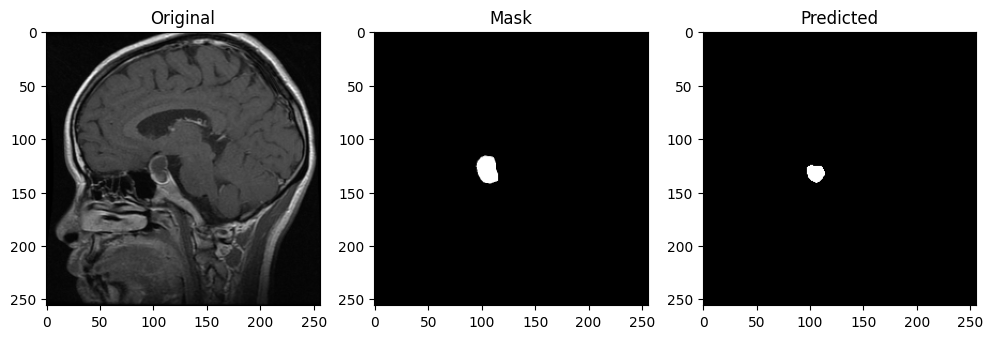

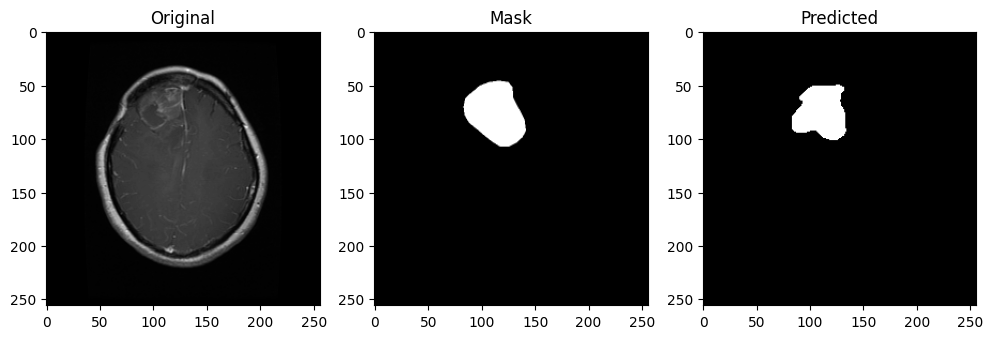

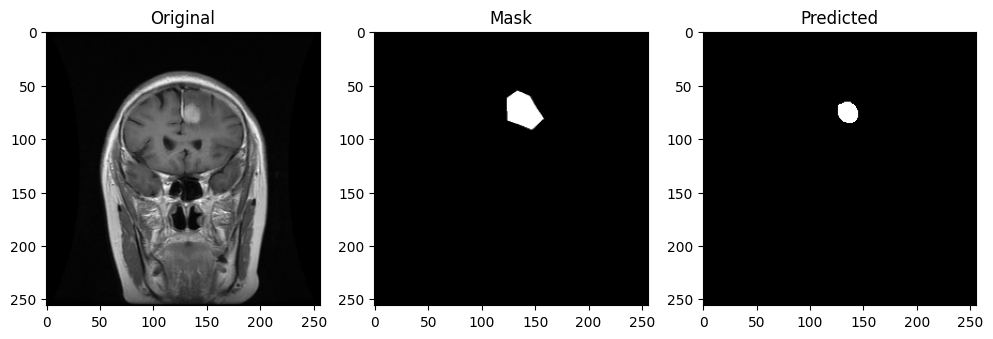

In [54]:
for i in range(10):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title('Original')
    plt.imshow(x_test[i+5], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Mask')
    plt.imshow(y_test[i+5].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Predicted')
    plt.imshow(y_pred[i+5].squeeze(), cmap='gray')

    plt.show()